# Calculating contributing geologic units to Mataquito River

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors
import rasterio
from rasterio.plot import show
from pyproj import Proj, transform

In [3]:
# import excel file
excel_path = "/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Geology/subwatershed_geologic_units_data.xlsx"
xls = pd.ExcelFile(excel_path)

# get sheet names
sheet_names = xls.sheet_names

In [4]:
# Define non-geologic units to exclude from calculations
non_geologic_units = ['Lag', 'G', 'arg']

# create dictionary for stats on each subwatershed
def create_summary_dataframe(xls, sheet_names, exclude_units=None):
    if exclude_units is None:
        exclude_units = []
    
    summaries = {}
    excluded_summaries = {}
    
    for sheet in sheet_names:
        df = xls.parse(sheet)
        # ensure the columns are available
        if 'GEO' in df.columns and 'area_km2' in df.columns:
            df = df.dropna(subset=['GEO', 'area_km2'])
            
            # separate excluded units from geologic units
            excluded_df = df[df['GEO'].isin(exclude_units)]
            geologic_df = df[~df['GEO'].isin(exclude_units)]
            
            # process excluded units (for reporting only)
            if not excluded_df.empty:
                excluded_grouped = excluded_df.groupby('GEO', as_index=False)['area_km2'].sum()
                excluded_grouped.insert(0, 'Subwatershed', sheet)
                excluded_summaries[sheet] = excluded_grouped
            
            # process geologic units
            if not geologic_df.empty:
                grouped = geologic_df.groupby('GEO', as_index=False)['area_km2'].sum()
                total_geologic_area = grouped['area_km2'].sum()
                grouped['percent'] = (grouped['area_km2'] / total_geologic_area) * 100
                # add subwatershed name as a column 
                grouped.insert(0, 'Subwatershed', sheet)
                summaries[sheet] = grouped
    
    # create summary dataframes
    summary_df = pd.concat(summaries.values(), ignore_index=True) if summaries else pd.DataFrame()
    excluded_df_combined = pd.concat(excluded_summaries.values(), ignore_index=True) if excluded_summaries else pd.DataFrame()
    
    return summary_df, summaries, excluded_df_combined, excluded_summaries

In [7]:
summary_df, summaries, excluded_df, excluded_summaries = create_summary_dataframe(xls, sheet_names, non_geologic_units)

# Print results for each subwatershed
for key in summaries:
    print(f"\n{'='*60}")
    print(f"GEOLOGIC UNIT SUMMARY — {key}")
    print(f"{'='*60}")
    
    # Show geologic units
    sorted_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
    print("\nGEOLOGIC UNITS:")
    print(sorted_df.to_string(index=False, float_format='%.3f'))
    
    geologic_total = sorted_df['area_km2'].sum()
    print(f"\nTotal geologic area: {geologic_total:.3f} km²")
    
    # Show excluded units if present
    if key in excluded_summaries:
        excluded_sorted = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)
        print(f"\nEXCLUDED UNITS (water bodies & unmapped areas):")
        print(excluded_sorted.to_string(index=False, float_format='%.2f'))
        
        excluded_total = excluded_sorted['area_km2'].sum()
        total_area = geologic_total + excluded_total
        excluded_percent = (excluded_total / total_area) * 100
        
        print(f"\nTotal excluded area: {excluded_total:.3f} km² ({excluded_percent:.2f}% of total)")
        print(f"Total subwatershed area: {total_area:.3f} km²")
    else:
        print(f"\nNo excluded units found in {key}")

# Show unique geologic units found
print(f"\n{'='*60}")
if not summary_df.empty:
    unique_geo_units = sorted(summary_df['GEO'].unique())
    print(f"\nUnique geologic units found: {len(unique_geo_units)}")
    print("Units:", ", ".join(unique_geo_units))


GEOLOGIC UNIT SUMMARY — CT-1_w_geo

GEOLOGIC UNITS:
 GEO  area_km2  percent
OM2c   635.204   46.019
PPl3   292.223   21.171
Pl3t   203.481   14.742
 Q3i    92.580    6.707
  Q1    82.445    5.973
  Mg    39.887    2.890
 DC4    34.499    2.499

Total geologic area: 1380.320 km²

EXCLUDED UNITS (water bodies & unmapped areas):
GEO  area_km2
  G      1.38

Total excluded area: 1.377 km² (0.10% of total)
Total subwatershed area: 1381.697 km²

GEOLOGIC UNIT SUMMARY — CT-10_w_geo

GEOLOGIC UNITS:
  GEO  area_km2  percent
 OM2c  2205.493   45.545
   Q1   770.786   15.917
 Pl3t   343.074    7.085
 PPl3   334.284    6.903
 Kia2   252.975    5.224
 Q3av   194.926    4.025
  Q3i   159.793    3.300
 Js1c   141.752    2.927
   Mg   138.264    2.855
 Js1m    75.483    1.559
   Qf    75.041    1.550
Kia1c    37.569    0.776
  DC4    34.499    0.712
 Kiag    27.608    0.570
 JK1m    19.936    0.412
 Mimg    19.338    0.399
 Ki2c    11.592    0.239

Total geologic area: 4842.415 km²

EXCLUDED UNITS (

In [18]:
summary_df.to_excel('geologic_area-percents.xlsx', index=False)

In [20]:
# Excel file of data
import pandas as pd

# Set the output Excel path
output_path = "combined_subwatershed_summary.xlsx"

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    worksheet = writer.book.add_worksheet("Geologic Summary")
    writer.sheets["Geologic Summary"] = worksheet

    row = 0  # Start at top of the sheet

    for key in summaries:
        geo_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
        
        # Write subwatershed title
        worksheet.write(row, 0, f"Geologic Unit Summary — {key}")
        row += 2

        # Write geologic units table
        geo_df.to_excel(writer, sheet_name="Geologic Summary", index=False, startrow=row, startcol=0, header=True)
        row += len(geo_df) + 1

        # Write geologic total
        geologic_total = geo_df['area_km2'].sum()
        worksheet.write(row, 0, 'Total geologic area:')
        worksheet.write(row, 1, geologic_total)
        row += 2

        # If excluded units exist, write them
        if key in excluded_summaries:
            excluded_df = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)

            worksheet.write(row, 0, 'Excluded Units (water bodies & unmapped areas):')
            row += 1

            excluded_df.to_excel(writer, sheet_name="Geologic Summary", index=False, startrow=row, startcol=0, header=True)
            row += len(excluded_df) + 1

            excluded_total = excluded_df['area_km2'].sum()
            total_area = geologic_total + excluded_total
            excluded_percent = (excluded_total / total_area) * 100

            worksheet.write(row, 0, 'Total excluded area:')
            worksheet.write(row, 1, excluded_total)
            row += 1
            worksheet.write(row, 0, 'Excluded area percent:')
            worksheet.write(row, 1, excluded_percent)
            row += 1
            worksheet.write(row, 0, 'Total subwatershed area:')
            worksheet.write(row, 1, total_area)
            row += 2
        else:
            worksheet.write(row, 0, f"No excluded units found in {key}")
            row += 2

        # Add a blank row between blocks
        row += 2


## Latex

In [ ]:
summary_df.to_excel('mata_geologic_units.xlsx', index=False, sheet_name='Combined_Summary')
def generate_latex_tables(summaries, excluded_summaries, summary_df):
    """
    Generate LaTeX tables from geologic unit summary data.
    
    Parameters:
    - summaries: dict of DataFrames with geologic unit data for each subwatershed
    - excluded_summaries: dict of DataFrames with excluded unit data
    - summary_df: combined DataFrame with all unique geologic units
    
    Returns:
    - string: Complete LaTeX document content
    """
    
    latex_content = []
    
    # Document header
    latex_content.extend([
        "\\documentclass[11pt]{article}",
        "\\usepackage[margin=1in]{geometry}",
        "\\usepackage{booktabs}",
        "\\usepackage{array}",
        "\\usepackage{longtable}",
        "\\usepackage{multirow}",
        "\\usepackage{siunitx}",
        "\\usepackage{xcolor}",
        "",
        "% Define column types for better formatting",
        "\\newcolumntype{L}[1]{>{\\raggedright\\arraybackslash}p{#1}}",
        "\\newcolumntype{C}[1]{>{\\centering\\arraybackslash}p{#1}}",
        "\\newcolumntype{R}[1]{>{\\raggedleft\\arraybackslash}p{#1}}",
        "",
        "\\title{Geologic Unit Summary Tables}",
        "\\author{Generated from Python Analysis}",
        "\\date{\\today}",
        "",
        "\\begin{document}",
        "",
        "\\maketitle",
        ""
    ])
    
    # Generate tables for each subwatershed
    for i, key in enumerate(summaries.keys()):
        # Clean subwatershed name for LaTeX (replace underscores, etc.)
        clean_key = key.replace('_', '\\_').replace('&', '\\&')
        
        latex_content.extend([
            f"\\section{{Subwatershed: {clean_key}}}",
            ""
        ])
        
        # Geologic units table
        sorted_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
        
        latex_content.extend([
            "\\subsection{Geologic Units}",
            "\\begin{table}[h!]",
            "\\centering",
            f"\\caption{{Geologic Units Distribution - {clean_key}}}",
            "\\begin{tabular}{@{}L{3cm}S[table-format=3.2]S[table-format=2.1]@{}}",
            "\\toprule",
            "\\textbf{Geologic Unit} & \\textbf{Area (km²)} & \\textbf{Percent (\\%)} \\\\",
            "\\midrule"
        ])
        
        # Add data rows
        for _, row in sorted_df.iterrows():
            geo_unit = str(row['GEO']).replace('_', '\\_').replace('&', '\\&')
            latex_content.append(f"{geo_unit} & {row['area_km2']:.2f} & {row['percent']:.1f} \\\\")
        
        # Add total row
        total_area = sorted_df['area_km2'].sum()
        latex_content.extend([
            "\\midrule",
            f"\\textbf{{Total}} & \\textbf{{{total_area:.2f}}} & \\textbf{{100.0}} \\\\",
            "\\bottomrule",
            "\\end{tabular}",
            "\\end{table}",
            ""
        ])
        
        # Excluded units table (if present)
        if key in excluded_summaries and not excluded_summaries[key].empty:
            excluded_sorted = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)
            
            latex_content.extend([
                "\\subsection{Excluded Units}",
                "\\begin{table}[h!]",
                "\\centering",
                f"\\caption{{Excluded Units (Water Bodies \\& Unmapped Areas) - {clean_key}}}",
                "\\begin{tabular}{@{}L{4cm}S[table-format=2.2]@{}}",
                "\\toprule",
                "\\textbf{Excluded Unit Type} & \\textbf{Area (km²)} \\\\",
                "\\midrule"
            ])
            
            # Add excluded unit rows
            for _, row in excluded_sorted.iterrows():
                geo_unit = str(row['GEO']).replace('_', '\\_').replace('&', '\\&')
                latex_content.append(f"{geo_unit} & {row['area_km2']:.2f} \\\\")
            
            # Add excluded total
            excluded_total = excluded_sorted['area_km2'].sum()
            total_subwatershed_area = total_area + excluded_total
            excluded_percent = (excluded_total / total_subwatershed_area) * 100
            
            latex_content.extend([
                "\\midrule",
                f"\\textbf{{Total Excluded}} & \\textbf{{{excluded_total:.2f}}} \\\\",
                "\\bottomrule",
                "\\end{tabular}",
                "\\end{table}",
                ""
            ])
            
            # Summary statistics
            latex_content.extend([
                "\\textbf{Summary Statistics:}",
                "\\begin{itemize}",
                f"\\item Total geologic area: {total_area:.2f} km²",
                f"\\item Total excluded area: {excluded_total:.2f} km² ({excluded_percent:.1f}\\% of total)",
                f"\\item Total subwatershed area: {total_subwatershed_area:.2f} km²",
                "\\end{itemize}",
                ""
            ])
        else:
            latex_content.extend([
                f"\\textbf{{Note:}} No excluded units found in {clean_key}",
                f"\\textbf{{Total subwatershed area:}} {total_area:.2f} km²",
                ""
            ])
        
        # Add page break between subwatersheds (except for the last one)
        if i < len(summaries) - 1:
            latex_content.append("\\newpage")
            latex_content.append("")
    
    # Summary of unique geologic units
    if not summary_df.empty:
        unique_geo_units = sorted(summary_df['GEO'].unique())
        num_units = len(unique_geo_units)
        
        latex_content.extend([
            "\\section{Summary of All Unique Geologic Units}",
            "",
            f"\\textbf{{Total unique geologic units found:}} {num_units}",
            ""
        ])
        
        # Create a formatted list of units (handle long lists by breaking into columns)
        if num_units <= 20:
            # Short list - simple table format
            latex_content.extend([
                "\\begin{table}[h!]",
                "\\centering",
                "\\caption{Complete List of Unique Geologic Units}",
                "\\begin{tabular}{@{}L{2cm}L{2cm}L{2cm}L{2cm}@{}}",
                "\\toprule",
                "\\multicolumn{4}{c}{\\textbf{Geologic Unit Codes}} \\\\",
                "\\midrule"
            ])
            
            # Add units in rows of 4
            for i in range(0, len(unique_geo_units), 4):
                row_units = unique_geo_units[i:i+4]
                # Clean unit names for LaTeX
                clean_units = [unit.replace('_', '\\_').replace('&', '\\&') for unit in row_units]
                # Pad with empty cells if needed
                while len(clean_units) < 4:
                    clean_units.append("")
                latex_content.append(" & ".join(clean_units) + " \\\\")
            
            latex_content.extend([
                "\\bottomrule",
                "\\end{tabular}",
                "\\end{table}"
            ])
        else:
            # Long list - paragraph format
            clean_units = [unit.replace('_', '\\_').replace('&', '\\&') for unit in unique_geo_units]
            units_text = ", ".join(clean_units)
            latex_content.extend([
                "\\textbf{Geologic Units:}",
                "",
                units_text
            ])
    
    # Document footer
    latex_content.extend([
        "",
        "\\end{document}"
    ])
    
    return "\n".join(latex_content)


def save_latex_file(latex_content, filename="geologic_summary.tex"):
    """
    Save LaTeX content to a file.
    
    Parameters:
    - latex_content: string with LaTeX code
    - filename: output filename
    """
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(latex_content)
    print(f"LaTeX file saved as: {filename}")


def create_summary_table_only(summaries, excluded_summaries):
    """
    Create a simplified summary table with all subwatersheds in one table.
    
    Parameters:
    - summaries: dict of DataFrames with geologic unit data
    - excluded_summaries: dict of DataFrames with excluded unit data
    
    Returns:
    - string: LaTeX table code for summary
    """
    
    latex_content = []
    
    latex_content.extend([
        "\\begin{longtable}{@{}L{3cm}S[table-format=3.2]S[table-format=2.2]S[table-format=3.2]@{}}",
        "\\caption{Summary of All Subwatersheds} \\\\",
        "\\toprule",
        "\\textbf{Subwatershed} & \\textbf{Geologic Area} & \\textbf{Excluded Area} & \\textbf{Total Area} \\\\",
        "& \\textbf{(km²)} & \\textbf{(km²)} & \\textbf{(km²)} \\\\",
        "\\midrule",
        "\\endfirsthead",
        "",
        "\\multicolumn{4}{c}{{\\tablename\\ \\thetable{} -- continued from previous page}} \\\\",
        "\\toprule",
        "\\textbf{Subwatershed} & \\textbf{Geologic Area} & \\textbf{Excluded Area} & \\textbf{Total Area} \\\\",
        "& \\textbf{(km²)} & \\textbf{(km²)} & \\textbf{(km²)} \\\\",
        "\\midrule",
        "\\endhead",
        "",
        "\\bottomrule",
        "\\multicolumn{4}{r}{{Continued on next page}} \\\\",
        "\\endfoot",
        "",
        "\\bottomrule",
        "\\endlastfoot"
    ])
    
    total_geologic = 0
    total_excluded = 0
    
    for key in summaries.keys():
        clean_key = key.replace('_', '\\_').replace('&', '\\&')
        geologic_area = summaries[key]['area_km2'].sum()
        
        if key in excluded_summaries and not excluded_summaries[key].empty:
            excluded_area = excluded_summaries[key]['area_km2'].sum()
        else:
            excluded_area = 0
        
        total_area = geologic_area + excluded_area
        
        latex_content.append(f"{clean_key} & {geologic_area:.2f} & {excluded_area:.2f} & {total_area:.2f} \\\\")
        
        total_geologic += geologic_area
        total_excluded += excluded_area
    
    # Add totals row
    grand_total = total_geologic + total_excluded
    latex_content.extend([
        "\\midrule",
        f"\\textbf{{TOTAL}} & \\textbf{{{total_geologic:.2f}}} & \\textbf{{{total_excluded:.2f}}} & \\textbf{{{grand_total:.2f}}} \\\\",
        "\\end{longtable}"
    ])
    
    return "\n".join(latex_content)


# Main execution code
if __name__ == "__main__":
    # Assuming you have your data structures ready:
    # summaries, excluded_summaries, summary_df from your existing code
    
    # Generate complete LaTeX document
    latex_document = generate_latex_tables(summaries, excluded_summaries, summary_df)
    
    # Save to file
    save_latex_file(latex_document, "geologic_summary_complete.tex")
    
    # Generate summary table only
    summary_table = create_summary_table_only(summaries, excluded_summaries)
    
    # Save summary table separately
    with open("summary_table_only.tex", 'w', encoding='utf-8') as f:
        f.write(summary_table)
    
    print("LaTeX files generated successfully!")
    print("- Complete document: geologic_summary_complete.tex")
    print("- Summary table only: summary_table_only.tex")
    
    # Optional: Display the first few lines of the generated LaTeX
    print("\nFirst 20 lines of generated LaTeX:")
    print("=" * 50)
    lines = latex_document.split('\n')
    for line in lines[:20]:
        print(line)

# pie charts

In [ ]:
# Create pie charts
def create_pie_charts(summaries):
    """Create pie charts for each subwatershed"""
    print(f"\nCreating pie charts for {len(summaries)} subwatersheds...")
    
    # Get all unique GEO units across all subwatersheds
    all_geo_units = set()
    for data in summaries.values():
        all_geo_units.update(data['GEO'].values)
    all_geo_units = sorted(list(all_geo_units))
    
    # Create consistent color mapping for each GEO unit using multiple color palettes
    # Combine multiple color palettes to get more distinct colors
    colors1 = plt.cm.Set3(np.linspace(0, 1, 12))
    colors2 = plt.cm.Pastel1(np.linspace(0, 1, 9))
    colors3 = plt.cm.Dark2(np.linspace(0, 1, 8))
    colors4 = plt.cm.Accent(np.linspace(0, 1, 8))
    
    all_colors = np.concatenate([colors1, colors2, colors3, colors4])
    
    geo_color_map = {geo: all_colors[i % len(all_colors)] for i, geo in enumerate(all_geo_units)}
    
    # Calculate subplot layout
    n_subs = len(summaries)
    n_cols = 2 if n_subs > 1 else 1
    n_rows = (n_subs + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Handle single subplot case
    if n_subs == 1:
        axes = [axes]
    elif n_rows == 1 and n_cols > 1:
        axes = list(axes)
    elif n_rows > 1:
        axes = axes.flatten()
    
    # Create each pie chart
    for i, (subwatershed, data) in enumerate(summaries.items()):
        ax = axes[i]
        
        # Prepare labels, sizes, and colors for this subwatershed
        labels = []
        sizes = data['percent'].values
        chart_colors = []
        
        for _, row in data.iterrows():
            labels.append(f"{row['GEO']}")
            chart_colors.append(geo_color_map[row['GEO']])
        
        # Create pie chart
        ax.pie(sizes, labels=labels, colors=chart_colors, 
               startangle=90, textprops={'fontsize': 9})
        
        # Title
        ax.set_title(f"{subwatershed}\nTotal: {data['area_km2'].sum():.1f} km²", 
                    fontsize=12, fontweight='bold', pad=20)
        ax.axis('equal')
    
    # Hide unused subplots
    for i in range(len(summaries), len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()


In [ ]:
# Run the display and charts
create_pie_charts(summaries)

# Geologic map

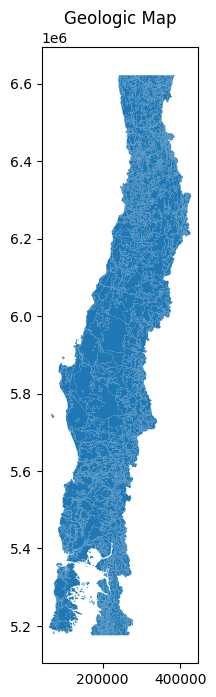

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load and plot the shapefile
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Quick plot
gdf.plot(figsize=(10, 8))
plt.title('Geologic Map')
plt.show()

In [9]:
import geopandas as gpd

gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')
print(gdf.columns)  # See all column names
print(gdf.head())   # See first few rows of data

Index(['AREA', 'PERIMETER', 'GEOLOGIA_', 'GEOLOGIA_I', 'AREATNT', 'PERIMETERT',
       'GEOLCEN_', 'GEOLCEN_ID', 'ITEM002', 'ITEM001', 'GEO_', 'GEO_ID', 'GEO',
       'geometry'],
      dtype='object')
           AREA  PERIMETER  GEOLOGIA_  GEOLOGIA_I       AREATNT  PERIMETERT  \
0  4.368528e+09   717803.1          2           2  4.368528e+09    711696.6   
1  5.214349e+09   923144.4          3           3  5.214349e+09    925742.1   
2  1.482286e+08   369994.3          4           4  1.482286e+08    370145.8   
3  2.979063e+09   380001.0          5           5  2.979063e+09    380973.6   
4  1.058153e+09   254435.2          6           6  1.058153e+09    255650.0   

   GEOLCEN_  GEOLCEN_ID  ITEM002  ITEM001  GEO_  GEO_ID   GEO  \
0      2078        2082      0.0      0.0  2080    2079  Pl3t   
1      1838        1851      0.0      0.0  1840    1839    Q1   
2      1974        1973      0.0      0.0  1975    1974   Rio   
3      1928        1933      0.0      0.0  1930    1929   CPg  

In [10]:
# Define colors based on the Chilean geological legend
geologic_colors = {
    # Quaternary
    'Q1': '#ffff6e',      # Pleistocene-Holocene alluvial deposits - pale yellow
    'Q3av': '#fae2c5',    # Quaternary volcanic avalanche - yellow
    'Q3i': '#e26eff',     # Quaternary stratovolcanoes - light red/pink
    'Qf': '#ffffe2',      # Fluvial deposits - very pale yellow
    # Neogene 
    'Pl3t': '#fae2e2',    # Pleistocene pyroclastic - orange
    'PPl3': '#ffe9e9',    # Pliocene-Pleistocene volcanic - orange-red
    'Mimg': '#fa51a8',    # Lower-Middle Miocene intrusive - peach
    'Mg': '#ff8ba8',      # Miocene volcanic - orange
    'OM2c': '#f0ffa8',    # Oligocene-Miocene volcanosedimentary - orange
    # Cretaceous
    'Kia1c': '#17ffa8',   # Upper Early Cretaceous sedimentary - light green
    'Kia2': '#cee26e',    # Late Lower-Early Upper Cretaceous - medium green
    'Ki2c': '#81ff81',    # Lower-Upper Cretaceous continental - pale green
    'Ki2m': '#8ba86e',    # Lower Cretaceous marine - bright green
    'Kiag': '#fa34c5',    # Late Lower-Early Upper Cretaceous intrusive - dark green
    'JK1m': '#85a800',    # Upper Jurassic-Lower Cretaceous marine - very pale green
    # Jurassic
    'Js1c': '#b7e2ff',    # Upper Jurassic continental - light blue
    'Js1m': '#17a8ff',    # Middle-Upper Jurassic marine - medium blue
    'Ji1m': '#ceffff',    # Lower-Middle Jurassic marine - blue
    'J3i': '#c5e2ff',     # Jurassic volcanic - dark blue
    'Jig': '#fa8b8b',     # Lower Jurassic intrusive - very dark blue
    # Triassic
    'Tr1m': '#d0e1f4',    # Upper Triassic marine - light purple
    'PzTr4': '#f0e2c5',   # Paleozoic-Triassic metamorphic - purple
    'CPg': '#ffe2ff',     # Cretaceous-Paleogene - mint green
    # Paleozoic
    'Pz4a': '#f2f2f2',    # Silurian-Carboniferous metamorphic - light brown
    'Pz4b': '#eaeaea',    # Silurian-Carboniferous metamorphic - brown
    'DC4': '#f0e2e2',     # Devonian-Carboniferous metamorphic - light gray
    # Special units
    'Rio': '#66CCFF',     # Rivers/water - light blue
    'arg': '000000',      # area outside geologic map 
    'Lag': '#66CCFF',     # Rivers/water - light blue
    'G' : '#66CCFF',     # Rivers/water - light blue

    # outside of mataquito
    'Q1g': '#f5ff00',     # 
    'M3i': '#ffe26e',     # 
    'Msg': '#ff3451',     # 
    'Pl3': '#e9e9ff',     # 
    'PPl1c': '#ffff17',     # 
    'Qe': '#f5ffa8',     # 
    'Kia3': '#6effa8',     # 
}

# Set transparency for geologic units (0.0 = fully transparent, 1.0 = fully opaque)
geologic_transparency = 0.7  # Adjust this value as needed

Lines loaded successfully
Faults loaded successfully
Fault symbols loaded successfully
Hillshade loaded successfully
North arrow PNG loaded successfully
Plot saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.png
PDF version saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.pdf


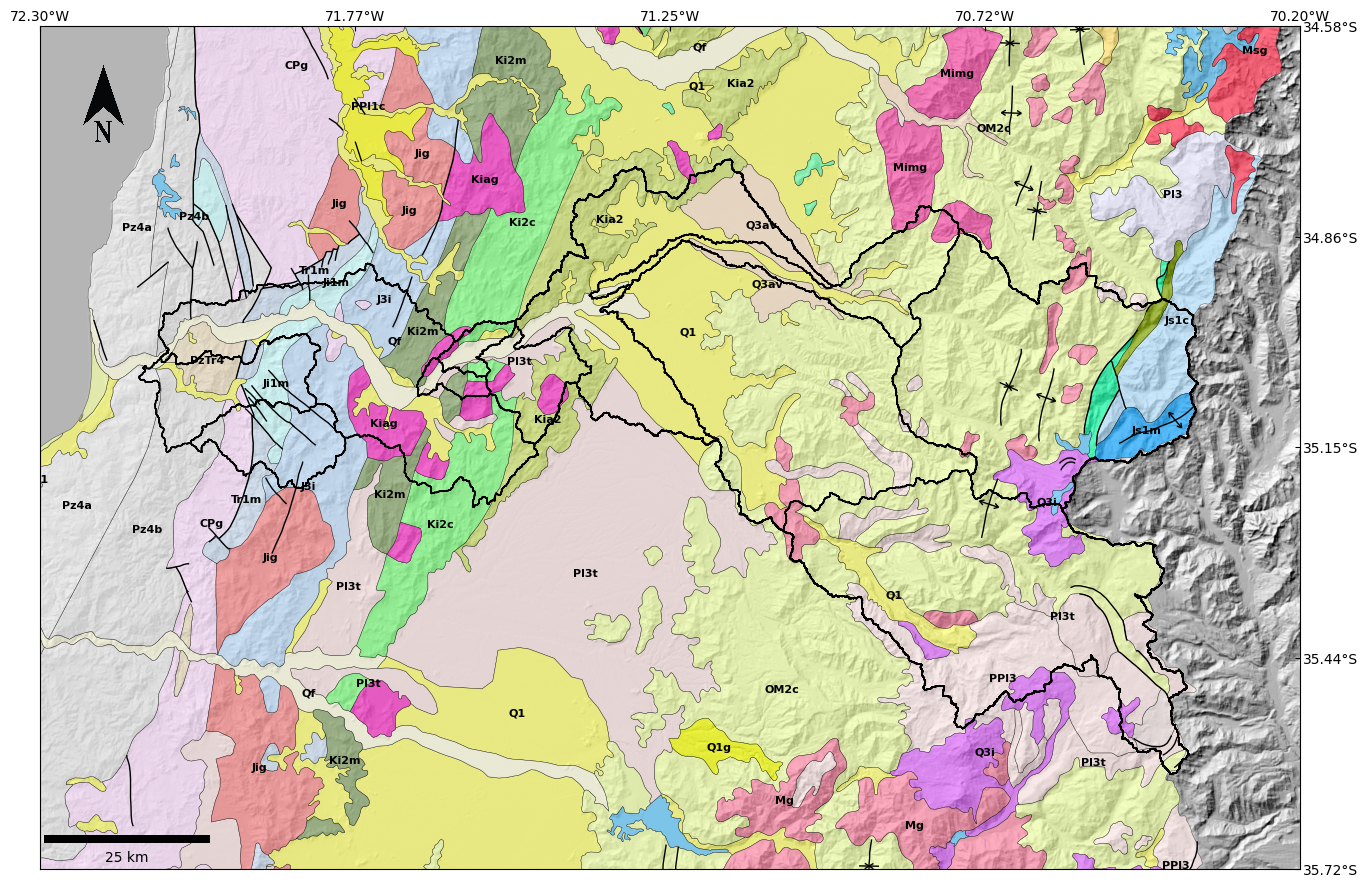

'print(f"\nGeologic units transparency set to: {geologic_transparency}")\nprint("Geologic units in your map and their colors:")\nfor unit in sorted(gdf[\'GEO\'].dropna().unique()):\n    color = geologic_colors.get(unit, \'#DDDDDD\')\n    print(f"{unit}: {color}")'

In [22]:
# Load the geological data
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Load and overlay the watershed boundary
watershed_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/subwatersheds30m.shp'
watershed_gdf = gpd.read_file(watershed_path)
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Load and overlay lines (no augmentations)
lines_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/centros-line_centro_u19.shp'
try:
    lines_gdf = gpd.read_file(lines_path)
    lines_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Lines loaded successfully")
except Exception as e:
    print(f"Could not load lines: {e}")

# Load and overlay faults (no augmentations)
faults_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas_centro_u19.shp'
try:
    faults_gdf = gpd.read_file(faults_path)
    faults_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Faults loaded successfully")
except Exception as e:
    print(f"Could not load faults: {e}")

# Load and overlay fault symbols (no augmentations)
faultsymb_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas-simb_centro_u19.shp'
try:
    faultsymb_gdf = gpd.read_file(faultsymb_path)
    faultsymb_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Fault symbols loaded successfully")
except Exception as e:
    print(f"Could not load fault symbols: {e}")

#----------------------------------------------------------

""" Create the plot """
fig, ax = plt.subplots(figsize=(14, 10))

# Set bounds based on your coordinates
x_coords = [201707, 391646, 286002, 307351]
y_coords = [6117461, 6095743, 6042001, 6168995]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Load and display hillshade FIRST (as background)
hillshade_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/hillshademauleregion.tif'
try:
    with rasterio.open(hillshade_path) as src:
        show(src, ax=ax, cmap='gray', alpha=1.0)
    print("Hillshade loaded successfully")
except Exception as e:
    print(f"Could not load hillshade: {e}")

# Plot each geologic unit with transparency OVER the hillshade
for unit in gdf['GEO'].unique():
    unit_data = gdf[gdf['GEO'] == unit]
    color = geologic_colors.get(unit, '#231f20')  # Default black if unit not found
    unit_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, 
                   alpha=geologic_transparency)
    
# Size threshold in square meters (5 km² = 5,000,000 m²)
min_area_threshold = 50000000  # 5 km² - adjust as needed
# ADD LABELS FOR GEOLOGIC UNITS (only within bounds and above size threshold)
for unit in gdf['GEO'].unique():
    if pd.notna(unit):  # Skip NaN values
        unit_data = gdf[gdf['GEO'] == unit]
        # For each polygon in this unit
        for idx, row in unit_data.iterrows():
            # Check if polygon is large enough and centroid is within bounds
            if row.geometry.area >= min_area_threshold:
                centroid = row.geometry.centroid
                # Only add label if centroid is within plot bounds
                if (x_min <= centroid.x <= x_max and y_min <= centroid.y <= y_max):
                    ax.text(centroid.x, centroid.y, str(unit), 
                           fontsize=8, ha='center', va='center', weight='bold', clip_on=True)

# Overlay the watershed boundary
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Overlay lines (if loaded)
if 'lines_gdf' in locals() and lines_gdf is not None:
    lines_gdf.plot(ax=ax, color='black', linewidth=1)
# Overlay faults (if loaded)
if 'faults_gdf' in locals() and faults_gdf is not None:
    faults_gdf.plot(ax=ax, color='black', linewidth=1)
# Overlay fault symbols (if loaded)
if 'faultsymb_gdf' in locals() and faultsymb_gdf is not None:
    faultsymb_gdf.plot(ax=ax, color='black', linewidth=1)

# Load and display north arrow
hillshade_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/north_arrow.png'

# north arrow
try:
    from matplotlib.image import imread
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    
    north_arrow_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/north_arrow.png'
    north_arrow_img = imread(north_arrow_path)
    # Create an OffsetImage with the north arrow
    imagebox = OffsetImage(north_arrow_img, zoom=0.05)  # Adjust zoom as needed
    # Position it in the upper right corner
    ab = AnnotationBbox(imagebox, (0.05, 0.90), 
                        xycoords='axes fraction',
                        frameon=False)
    ax.add_artist(ab)
    print("North arrow PNG loaded successfully")
    
except Exception as e:
    print(f"Could not load north arrow PNG: {e}")

# Add scale bar without white background
try:
    from matplotlib_scalebar.scalebar import ScaleBar
    scalebar = ScaleBar(1, units="m", location="lower left", 
                       length_fraction=0.25, width_fraction=0.01,
                       box_alpha=0,  # Make background transparent
                       box_color='none',  # Remove box color
                       color='black')  # Set scale bar color
    ax.add_artist(scalebar)
except ImportError:
    # Fallback manual scale bar (no background box)
    scale_length = 20000  # 20 km
    scale_x = x_min + 0.05 * (x_max - x_min)
    scale_y = y_min + 0.05 * (y_max - y_min)
    
    ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], 'k-', linewidth=3)
    ax.text(scale_x + scale_length/2, scale_y + 2000, '20 km', ha='center', fontsize=10)

# Convert UTM coordinates to lat/long for axis labels
# Define UTM Zone 19S projection (typical for Chile)
utm_proj = Proj(proj='utm', zone=19, south=True, datum='WGS84')
wgs84_proj = Proj(proj='latlong', datum='WGS84')
# Convert corner coordinates to lat/long
x_corners = [x_min, x_max]
y_corners = [y_min, y_max]
lon_corners, lat_corners = transform(utm_proj, wgs84_proj, x_corners, y_corners)
# Create custom tick locations and labels
n_ticks = 5  # Number of ticks on each axis
# X-axis (longitude)
x_tick_positions = np.linspace(x_min, x_max, n_ticks)
x_tick_lons, _ = transform(utm_proj, wgs84_proj, x_tick_positions, [y_min] * n_ticks)
x_tick_labels = [f"{lon:.2f}°W" for lon in abs(x_tick_lons)]
# Y-axis (latitude) 
y_tick_positions = np.linspace(y_min, y_max, n_ticks)
_, y_tick_lats = transform(utm_proj, wgs84_proj, [x_min] * n_ticks, y_tick_positions)
y_tick_labels = [f"{lat:.2f}°S" for lat in abs(y_tick_lats)]
# Set custom ticks and labels
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels)
# Put labels on top and right side
ax.xaxis.tick_top()
ax.yaxis.tick_right()
# Put ticks inside the figure
ax.tick_params(direction='in', pad=4)
# Align tick labels inside the axes
ax.tick_params(axis='x', direction='in', pad=2, labeltop=True, labelbottom=False)
ax.tick_params(axis='y', direction='in', pad=2, labelright=True, labelleft=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Create output directory and save the plot
import os 
output_dir = "/Users/Glong1/Desktop/Andes/Mataquito_Manuscript"
os.makedirs(output_dir, exist_ok=True)
# Save the figure with high quality settings
output_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Plot saved to: {output_path}")
# Also save as PDF for publication quality
pdf_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.pdf')
plt.savefig(pdf_path, bbox_inches='tight', facecolor='white')
print(f"PDF version saved to: {pdf_path}")

# Display the plot
plt.show()

# Print the units found in your data with their assigned colors
"""print(f"\nGeologic units transparency set to: {geologic_transparency}")
print("Geologic units in your map and their colors:")
for unit in sorted(gdf['GEO'].dropna().unique()):
    color = geologic_colors.get(unit, '#DDDDDD')
    print(f"{unit}: {color}")"""

# Extracts colors from geologic map legend

In [ ]:
import re
import xml.etree.ElementTree as ET
import colorsys

def extract_colors_from_svg(svg_file_path):
    """
    Extract all unique colors from an SVG file exported from Illustrator
    """
    colors = set()
    
    try:
        # Parse the SVG file
        tree = ET.parse(svg_file_path)
        root = tree.getroot()
        
        # Get the SVG content as string for regex parsing
        with open(svg_file_path, 'r', encoding='utf-8') as file:
            svg_content = file.read()
        
        # Patterns to match different color formats
        patterns = {
            'hex': r'#[0-9a-fA-F]{6}|#[0-9a-fA-F]{3}',
            'rgb': r'rgb\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\)',
            'rgba': r'rgba\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*[\d.]+\s*\)',
            'hsl': r'hsl\(\s*\d+\s*,\s*\d+%\s*,\s*\d+%\s*\)',
            'named': r'\b(?:red|blue|green|yellow|orange|purple|pink|brown|black|white|gray|grey|cyan|magenta|lime|navy|teal|olive|maroon|silver|aqua|fuchsia)\b'
        }
        
        # Extract colors using regex
        for color_type, pattern in patterns.items():
            matches = re.findall(pattern, svg_content, re.IGNORECASE)
            for match in matches:
                colors.add(match.lower())
        
        # Also check XML attributes directly
        for elem in root.iter():
            # Check common color attributes
            for attr in ['fill', 'stroke', 'stop-color', 'flood-color', 'lighting-color']:
                if attr in elem.attrib:
                    color_value = elem.attrib[attr]
                    if color_value not in ['none', 'transparent', 'inherit']:
                        colors.add(color_value.lower())
            
            # Check style attribute
            if 'style' in elem.attrib:
                style = elem.attrib['style']
                # Extract colors from CSS style
                css_colors = re.findall(r'(?:fill|stroke|stop-color):\s*([^;]+)', style)
                for color in css_colors:
                    color = color.strip()
                    if color not in ['none', 'transparent', 'inherit']:
                        colors.add(color.lower())
    
    except Exception as e:
        print(f"Error parsing SVG file: {e}")
        return set()
    
    return colors

def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple"""
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 3:
        hex_color = ''.join([c*2 for c in hex_color])
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_string_to_tuple(rgb_string):
    """Convert 'rgb(r,g,b)' string to RGB tuple"""
    numbers = re.findall(r'\d+', rgb_string)
    return tuple(int(n) for n in numbers)

def format_color_output(colors):
    """Format colors for nice output with multiple representations"""
    formatted_colors = []
    
    for color in sorted(colors):
        color_info = {'original': color}
        
        if color.startswith('#'):
            # Hex color
            try:
                rgb = hex_to_rgb(color)
                color_info['hex'] = color
                color_info['rgb'] = f"rgb({rgb[0]}, {rgb[1]}, {rgb[2]})"
                # Convert to HSL
                h, s, l = colorsys.rgb_to_hls(rgb[0]/255, rgb[1]/255, rgb[2]/255)
                color_info['hsl'] = f"hsl({int(h*360)}, {int(s*100)}%, {int(l*100)}%)"
            except:
                pass
        elif color.startswith('rgb('):
            # RGB color
            try:
                rgb = rgb_string_to_tuple(color)
                color_info['rgb'] = color
                color_info['hex'] = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
                h, s, l = colorsys.rgb_to_hls(rgb[0]/255, rgb[1]/255, rgb[2]/255)
                color_info['hsl'] = f"hsl({int(h*360)}, {int(s*100)}%, {int(l*100)}%)"
            except:
                pass
        
        formatted_colors.append(color_info)
    
    return formatted_colors

def main():
    svg_file_path = input("Enter the path to your SVG file: ").strip()
    
    print("Extracting colors from SVG...")
    colors = extract_colors_from_svg(svg_file_path)
    
    if not colors:
        print("No colors found in the SVG file.")
        return
    
    print(f"\nFound {len(colors)} unique colors:")
    print("-" * 50)
    
    formatted_colors = format_color_output(colors)
    
    for i, color_info in enumerate(formatted_colors, 1):
        print(f"{i}. {color_info['original']}")
        if 'hex' in color_info and 'rgb' in color_info:
            print(f"   Hex: {color_info['hex']}")
            print(f"   RGB: {color_info['rgb']}")
            if 'hsl' in color_info:
                print(f"   HSL: {color_info['hsl']}")
        print()
    
    # Save to file
    save_option = input("Save colors to a text file? (y/n): ").lower()
    if save_option == 'y':
        output_file = svg_file_path.replace('.svg', '_colors.txt')
        with open(output_file, 'w') as f:
            f.write(f"Colors extracted from: {svg_file_path}\n")
            f.write(f"Total unique colors: {len(colors)}\n\n")
            for i, color_info in enumerate(formatted_colors, 1):
                f.write(f"{i}. {color_info['original']}\n")
                if 'hex' in color_info:
                    f.write(f"   Hex: {color_info['hex']}\n")
                if 'rgb' in color_info:
                    f.write(f"   RGB: {color_info['rgb']}\n")
                if 'hsl' in color_info:
                    f.write(f"   HSL: {color_info['hsl']}\n")
                f.write("\n")
        print(f"Colors saved to: {output_file}")

if __name__ == "__main__":
    main()